[*********************100%%**********************]  1 of 1 completed
Epoch 1/50
8/8 [==============================] - 9s 6ms/step - loss: 0.1079
Epoch 2/50
8/8 [==============================] - 0s 5ms/step - loss: 0.0945
Epoch 3/50
8/8 [==============================] - 0s 5ms/step - loss: 0.0838
Epoch 4/50
8/8 [==============================] - 0s 6ms/step - loss: 0.0717
Epoch 5/50
8/8 [==============================] - 0s 6ms/step - loss: 0.0628
Epoch 6/50
8/8 [==============================] - 0s 5ms/step - loss: 0.0577
Epoch 7/50
8/8 [==============================] - 0s 6ms/step - loss: 0.0507
Epoch 8/50
8/8 [==============================] - 0s 4ms/step - loss: 0.0393
Epoch 9/50
8/8 [==============================] - 0s 5ms/step - loss: 0.0257
Epoch 10/50
8/8 [==============================] - 0s 7ms/step - loss: 0.0126
Epoch 11/50
8/8 [==============================] - 0s 7ms/step - loss: 0.0059
Epoch 12/50
8/8 [==============================] - 0s 5ms/step - loss: 0.0055
Epoc

 1,6


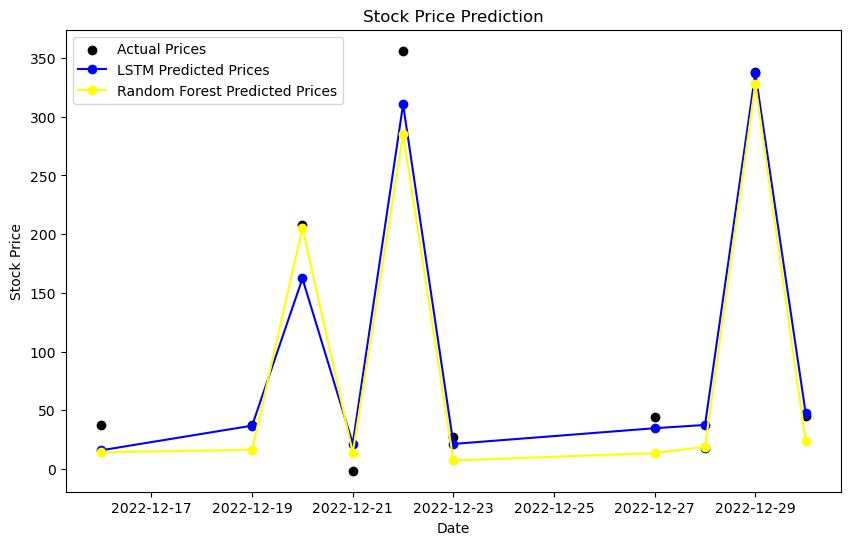


Actual price for the last day: 123.18

LSTM:
Predicted price for the last day: 112.24

Random Forests:
Predicted price for the last day: 120.52
            Model  Mean Squared Error (MSE)
0            LSTM                794.077378
5  Random Forests                676.267251


In [73]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

# Fetch data from Yahoo Finance
ticker = 'TSLA'
start_date = '2013-01-01'
end_date = '2023-01-01'
data = yf.download(ticker, start=start_date, end=end_date)

# Use only the 'Close' prices for simplicity
data = data[['Close']]

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

# Suppress the warning about feature names not being valid
scaler.feature_names_in_ = None

# Introduce noise into the data
noise_factor = 0.05
data_scaled_with_noise = data_scaled + noise_factor * np.random.randn(*data_scaled.shape)

# Prepare data for LSTM
def create_dataset(dataset, time_steps=1):
    X, y = [], []
    for i in range(len(dataset) - time_steps):
        a = dataset[i:(i + time_steps), 0]
        X.append(a)
        y.append(dataset[i + time_steps, 0])
    return np.array(X), np.array(y)

time_steps = 1  # You can adjust this based on your requirement
X, y = create_dataset(data_scaled_with_noise, time_steps)

# Reduce the size of the training set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9, random_state=42)

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=True))
model.add(LSTM(units=50))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the LSTM model
model.fit(X_train, y_train, epochs=50, batch_size=32)

# Predict on the test set using LSTM
y_pred_lstm = model.predict(X_test)

# Build and train the SVR model
svm_model = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
svm_model.fit(X_train.reshape(-1, time_steps), y_train)

# Predict on the test set using SVR
y_pred_svm = svm_model.predict(X_test.reshape(-1, time_steps))

# Build and train the Ridge Regression model with alpha = 10
ridge_model = Ridge(alpha=10)
ridge_model.fit(X_train.reshape(-1, time_steps), y_train)

# Predict on the test set using Ridge Regression
y_pred_ridge = ridge_model.predict(X_test.reshape(-1, time_steps))

# Build and train the Decision Tree model
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train.reshape(-1, time_steps), y_train)

# Predict on the test set using Decision Tree
y_pred_dt = dt_model.predict(X_test.reshape(-1, time_steps))

# Build and train the KNN model
knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(X_train.reshape(-1, time_steps), y_train)

# Predict on the test set using KNN
y_pred_knn = knn_model.predict(X_test.reshape(-1, time_steps))

# Build and train the Random Forests model
rf_model = RandomForestRegressor(n_estimators=50, max_depth=5, random_state=42)
rf_model.fit(X_train.reshape(-1, time_steps), y_train)

# Predict on the test set using Random Forests
y_pred_rf = rf_model.predict(X_test.reshape(-1, time_steps))

# Reshape predictions for inverse transform
y_pred_svm = y_pred_svm.reshape(-1, 1)
y_pred_lstm = y_pred_lstm.reshape(-1, 1)
y_pred_ridge = y_pred_ridge.reshape(-1, 1)
y_pred_dt = y_pred_dt.reshape(-1, 1)
y_pred_knn = y_pred_knn.reshape(-1, 1)
y_pred_rf = y_pred_rf.reshape(-1, 1)

# Inverse transform the scaled data
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_lstm_inv = scaler.inverse_transform(y_pred_lstm)
y_pred_svm_inv = scaler.inverse_transform(y_pred_svm)
y_pred_ridge_inv = scaler.inverse_transform(y_pred_ridge)
y_pred_dt_inv = scaler.inverse_transform(y_pred_dt)
y_pred_knn_inv = scaler.inverse_transform(y_pred_knn)
y_pred_rf_inv = scaler.inverse_transform(y_pred_rf)

# Calculate MSE for each model
mse_lstm = mean_squared_error(y_test_inv, y_pred_lstm_inv)
mse_svm = mean_squared_error(y_test_inv, y_pred_svm_inv)
mse_ridge = mean_squared_error(y_test_inv, y_pred_ridge_inv)
mse_dt = mean_squared_error(y_test_inv, y_pred_dt_inv)
mse_knn = mean_squared_error(y_test_inv, y_pred_knn_inv)
mse_rf = mean_squared_error(y_test_inv, y_pred_rf_inv)

# Separate the last day for prediction
last_day_data = data.iloc[-1:].values.reshape(1, -1)
last_day_data_scaled = scaler.transform(last_day_data)

# Predict the last day using LSTM
X_last_day_lstm = np.array([data_scaled[-time_steps:]])
X_last_day_lstm = np.reshape(X_last_day_lstm, (X_last_day_lstm.shape[0], X_last_day_lstm.shape[1], 1))
y_pred_last_day_lstm = model.predict(X_last_day_lstm)
y_pred_last_day_lstm_inv = scaler.inverse_transform(y_pred_last_day_lstm.reshape(-1, 1))

# Predict the last day using SVR
X_last_day_svm = last_day_data_scaled.repeat(time_steps, axis=0).reshape(1, -1)
y_pred_last_day_svm = svm_model.predict(X_last_day_svm.reshape(1, -1))
y_pred_last_day_svm_inv = scaler.inverse_transform(y_pred_last_day_svm.reshape(-1, 1))

# Predict the last day using Ridge Regression
y_pred_last_day_ridge = ridge_model.predict(last_day_data_scaled)
y_pred_last_day_ridge_inv = scaler.inverse_transform(y_pred_last_day_ridge.reshape(-1, 1))

# Predict the last day using Decision Tree
y_pred_last_day_dt = dt_model.predict(last_day_data_scaled)
y_pred_last_day_dt_inv = scaler.inverse_transform(y_pred_last_day_dt.reshape(-1, 1))

# Predict the last day using KNN
y_pred_last_day_knn = knn_model.predict(last_day_data_scaled)
y_pred_last_day_knn_inv = scaler.inverse_transform(y_pred_last_day_knn.reshape(-1, 1))

# Predict the last day using Random Forests
y_pred_last_day_rf = rf_model.predict(last_day_data_scaled)
y_pred_last_day_rf_inv = scaler.inverse_transform(y_pred_last_day_rf.reshape(-1, 1))

# Allow the user to select models to display
print("Select the models to display (enter the corresponding numbers separated by commas):")
print("1. LSTM")
print("2. SVM")
print("3. Ridge Regression")
print("4. Decision Tree")
print("5. KNN")
print("6. Random Forests")
selected_models = list(map(int, input().split(',')))

# Plot the results of all models
dates_test = data.index[-len(y_test):]
plt.figure(figsize=(10, 6))
plt.scatter(dates_test[-10:], y_test_inv[-10:], label='Actual Prices', color='black')
if 1 in selected_models:
    plt.plot(dates_test[-10:], y_pred_lstm_inv[-10:], label='LSTM Predicted Prices', color='blue', marker='o')
if 2 in selected_models:
    plt.plot(dates_test[-10:], y_pred_svm_inv[-10:], label='SVR Predicted Prices', color='green', marker='o')
if 3 in selected_models:
    plt.plot(dates_test[-10:], y_pred_ridge_inv[-10:], label='Ridge Regression Predicted Prices', color='red', marker='o')
if 4 in selected_models:
    plt.plot(dates_test[-10:], y_pred_dt_inv[-10:], label='Decision Tree Predicted Prices', color='orange', marker='o')
if 5 in selected_models:
    plt.plot(dates_test[-10:], y_pred_knn_inv[-10:], label='KNN Predicted Prices', color='purple', marker='o')
if 6 in selected_models:
    plt.plot(dates_test[-10:], y_pred_rf_inv[-10:], label='Random Forest Predicted Prices', color='yellow', marker='o')
plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

# Print actual price for the last day
last_day_actual_price = data.iloc[-1]['Close']
print(f"\nActual price for the last day: {last_day_actual_price:.2f}")

# Print predicted prices for the last day for selected models
if 1 in selected_models:
    print("\nLSTM:")
    print(f"Predicted price for the last day: {y_pred_last_day_lstm_inv[0][0]:.2f}")

if 2 in selected_models:
    print("\nSVR:")
    print(f"Predicted price for the last day: {y_pred_last_day_svm_inv[0][0]:.2f}")

if 3 in selected_models:
    print("\nRidge Regression:")
    print(f"Predicted price for the last day: {y_pred_last_day_ridge_inv[0][0]:.2f}")

if 4 in selected_models:
    print("\nDecision Tree:")
    print(f"Predicted price for the last day: {y_pred_last_day_dt_inv[0][0]:.2f}")

if 5 in selected_models:
    print("\nKNN:")
    print(f"Predicted price for the last day: {y_pred_last_day_knn_inv[0][0]:.2f}")

if 6 in selected_models:
    print("\nRandom Forests:")
    print(f"Predicted price for the last day: {y_pred_last_day_rf_inv[0][0]:.2f}")
        
# Create a table of MSE values for each selected model
selected_models_names = ['LSTM', 'SVR', 'Ridge Regression', 'Decision Tree', 'KNN', 'Random Forests']
selected_mses = [mse_lstm, mse_svm, mse_ridge, mse_dt, mse_knn, mse_rf]

selected_mse_table = pd.DataFrame({
    'Model': selected_models_names,
    'Mean Squared Error (MSE)': selected_mses
})
selected_mse_table = selected_mse_table[selected_mse_table['Model'].apply(lambda x: selected_models_names.index(x) + 1 in selected_models)]

print(selected_mse_table)
